In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
sns.set()
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (10, 7), 'axes.titlesize': 18})

In [2]:
train_df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
shops_df = pd.read_csv('shops.csv')
items_df = pd.read_csv('items.csv')
categories_df = pd.read_csv('item_categories.csv')

### Train data 

In [9]:
# some general info
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [95]:
train_df['date'] = pd.to_datetime(train_df.date, dayfirst=True)

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [12]:
# no nan values
train_df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Explore numerical variables like **item_price** and **item_cnt_day**

In [16]:
train_df.iloc[:,-2:].describe().round(2)
# there's -1 in price min value, probably that's a mistake, the median price is 399
# in item count, have the largest return amount of items is 22, and all quartiles equal to 1

,item_price,item_cnt_day
count,2935849.00,2935849.00
mean,890.85,1.24
std,1729.80,2.62
min,-1.00,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,307980.00,2169.00


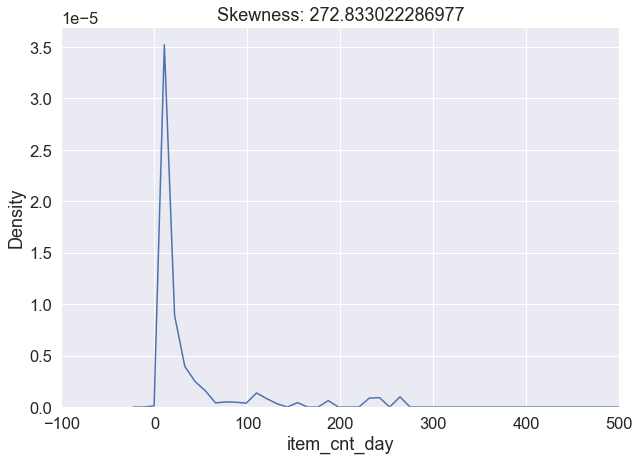

In [73]:
# the distribution if item count is very skewed
ax = sns.kdeplot(x=train_df.item_cnt_day)
ax.set_title('Skewness: {}'.format(str(stats.skew(train_df.item_cnt_day))))
ax.set_xlim(-100,500);

In [39]:
train_df.item_cnt_day.quantile(0.99)

5.0

In [37]:
train_df[train_df.item_cnt_day > 5.].shape[0] / train_df.shape[0]
# less than 1% of observations have item_cnt_day > 5

0.009336651850963724

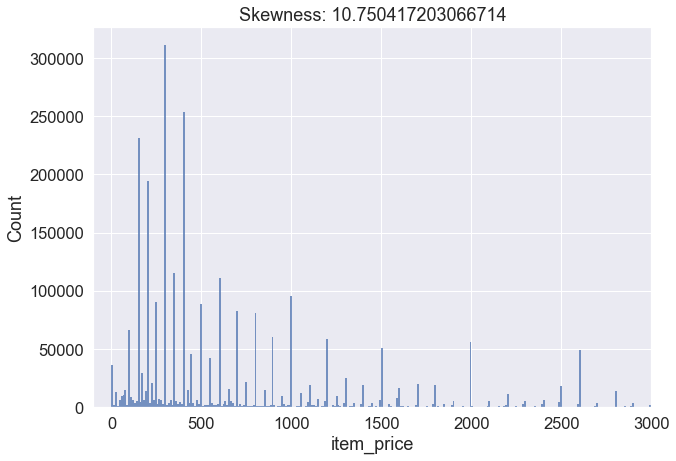

In [65]:
# the distribution of item price also is skewed
ax = sns.histplot(x=train_df.item_price)
ax.set_title('Skewness: {}'.format(str(stats.skew(train_df.item_price))))
ax.set_xlim(-100,3000.);

Analazying **item price** and **sales count** for each **date block** using line plot.

In [156]:
def monthly_trend_line_plot(df, date_col: str, x: str, agg_func: str, name: str, add_corr=False):
    df1 = df.groupby(date_col).agg({x:agg_func})
    df1.columns=[name]
    df1.reset_index(inplace=True)
    
    ax = sns.lineplot(data=df1, x=date_col, y=name)
    start, end = df1[date_col].min(), df1[date_col].max()
    ax.set_xticks(range(start, end+1, 3))
    if add_corr: ax.set_title('Correlation: {}'.format(df1.corr()[name][0].round(3)))
    return ax

Most sales were made on December both in 2013 and 2014, there's a decreasing trend of sales. Correlation is pretty high. 

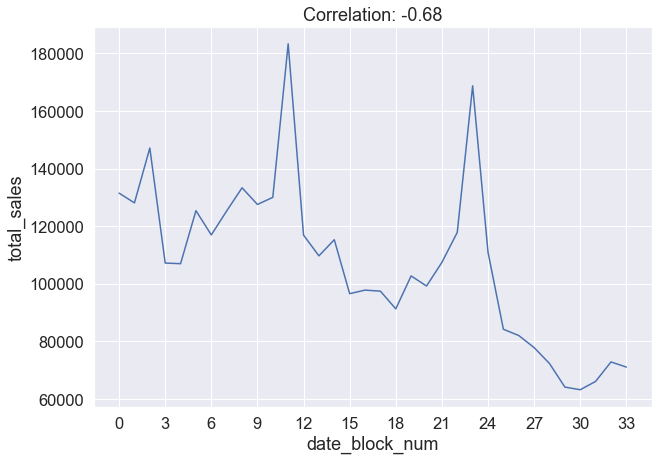

In [157]:
monthly_trend_line_plot(train_df, 'date_block_num', 'item_cnt_day', 'sum', 'total_sales', add_corr=True);

For item price I chose median agg function, as its distribution is very skewed.<br>The largest peaks of median price during the year were on December, there's an increasing trend of median price. Correlation is pretty high. 

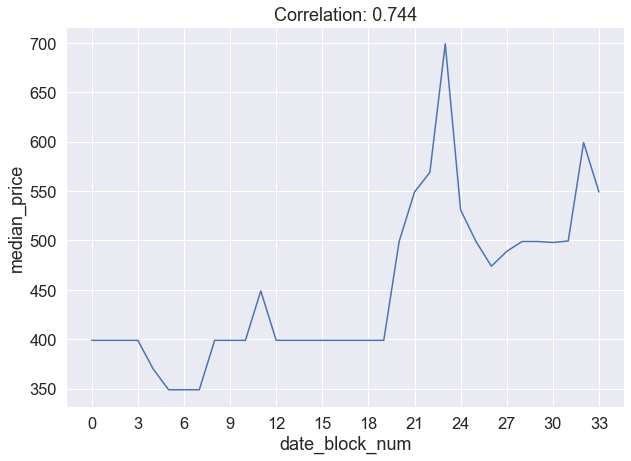

In [160]:
monthly_trend_line_plot(train_df, 'date_block_num', 'item_price', 'median', 'median_price', add_corr=True);

Add feature like **revenue**, which is combination of sales amount and its prices. We can see, that the revenue grows.

In [143]:
train_df['revenue'] = train_df.item_cnt_day * train_df.item_price

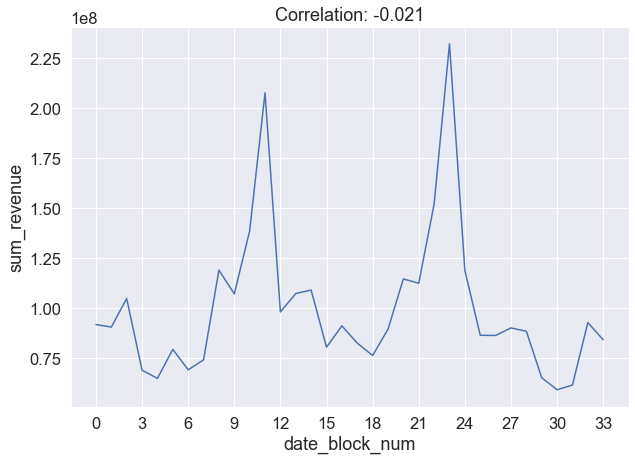

In [162]:
monthly_trend_line_plot(train_df, 'date_block_num', 'revenue', 'sum', 'sum_revenue', add_corr=True);

### By far we've examined amount of sales and its prices: 
both variables have skewed distribution, which means that we should:<br>1) transform data or<br>2) choose algorithm which is robust to outliers or<br>3) delete outliers<br>December is the most profitable and demanded montn.<br>The amount of sales has a decreasing trend and the price has an increasing trend, which is an ordinary situation in countries which are getting poorer and closer to crisis like in Russia. Both variables have strong correlation with date block variable.<br>Now we'll dive into shops and items and grab info from these dfs.

In [163]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [164]:
# both tables are connected through item_category_id, for convenience join them
categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [168]:
items_cats_df = pd.merge(items_df, categories_df, on='item_category_id')
items_cats_df.isna().sum()

item_name             0
item_id               0
item_category_id      0
item_category_name    0
dtype: int64

In [176]:
items_cats_df.item_category_name.nunique()
# 84 unique items

84

In [90]:
def make_bar_plot(df, x: str, top_n: int, y_label: str, w_group=False, group_var=None, agg_func=None):
    # if want to group by a specified feature
    if w_group:
        df = df.groupby(group_var).agg({x:agg_func})
        df.columns = [y_label]
        df.sort_values(by=y_label, inplace=True, ascending=False)
        
    # if want see the head categories
    if top_n > 0:
        if w_group:
            categories = df[:top_n].index
            top_vals = df[:top_n][y_label]
        else:
            categories = df[x].value_counts()[:top_n].index
            top_vals = df[x].value_counts()[:top_n]
    # if the tail
    else:
        if w_group:
            categories = df[top_n:].index
            top_vals = df[top_n:][y_label]
        else:
            categories = df[x].value_counts()[top_n:].index
            top_vals = df[x].value_counts()[top_n:] 
        
    ax = sns.barplot(x=categories, y=top_vals)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set(ylabel=y_label)
    return ax

**The most popular** items are connected with PC games, TV.

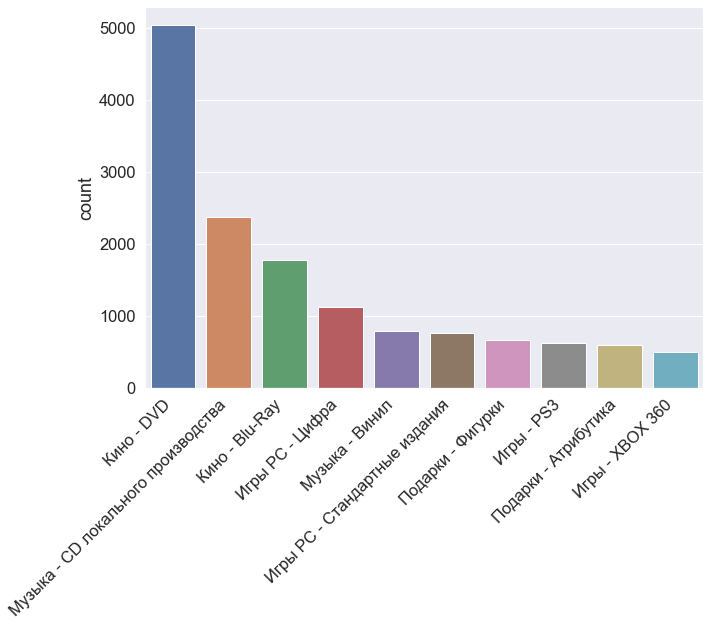

In [198]:
make_bar_plot(items_cats_df, x='item_category_name', top_n=10, y_label='count');

5 out of 10 **the least popular** items are books :( As we have such differences, we can then extract categories from item names, which probably can be a good feature for target variable

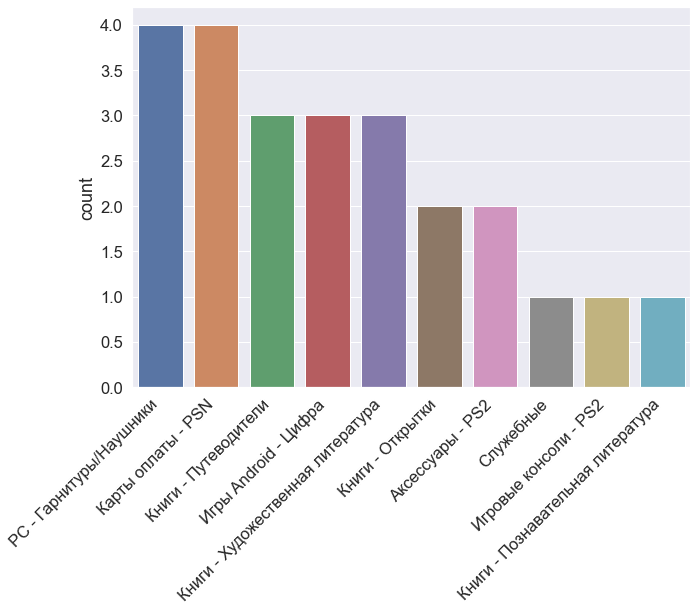

In [202]:
make_bar_plot(items_cats_df, x='item_category_name', top_n=-10, y_label='count');

### Now shops
<br>We have here some confusing misspellings like "!Якутск Орджоникидзе, 56 фран" and "Якутск Орджоникидзе, 56"; and another thing is that **most shop names contain the city name on the 1st place**. That's all, we can't observe **shops_df** any more, so let's merge this df with **train_df** (and **test_df**!) in order to handle the 1st problem both for train data and test data and then explore shop names and corresponding numeric variables. 

In [203]:
shops_df

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [204]:
# Якутск Орджоникидзе, 56
train_df.loc[train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train_df.loc[train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train_df.loc[train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

In [206]:
shops_df.drop(index=[0, 1, 10], inplace=True)

In [208]:
train_df = pd.merge(train_df, shops_df, on='shop_id')
train_df.isna().sum() # no nans, merging was succesfull

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
revenue           0
shop_name         0
dtype: int64

**The most popular (by count) and with the most sales shops come from large cities such as Moscow, St.Petersburg.**

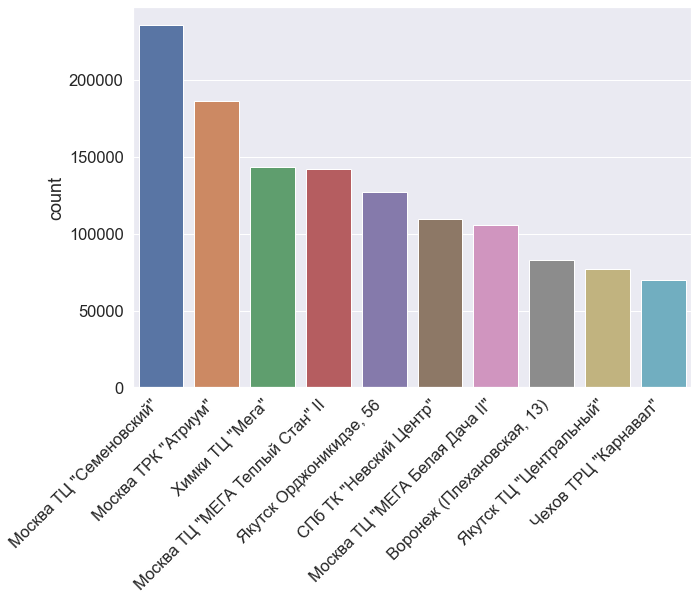

In [211]:
make_bar_plot(train_df, 'shop_name', top_n=10, y_label='count');

**At the same time some shops from Moscow are less visited**

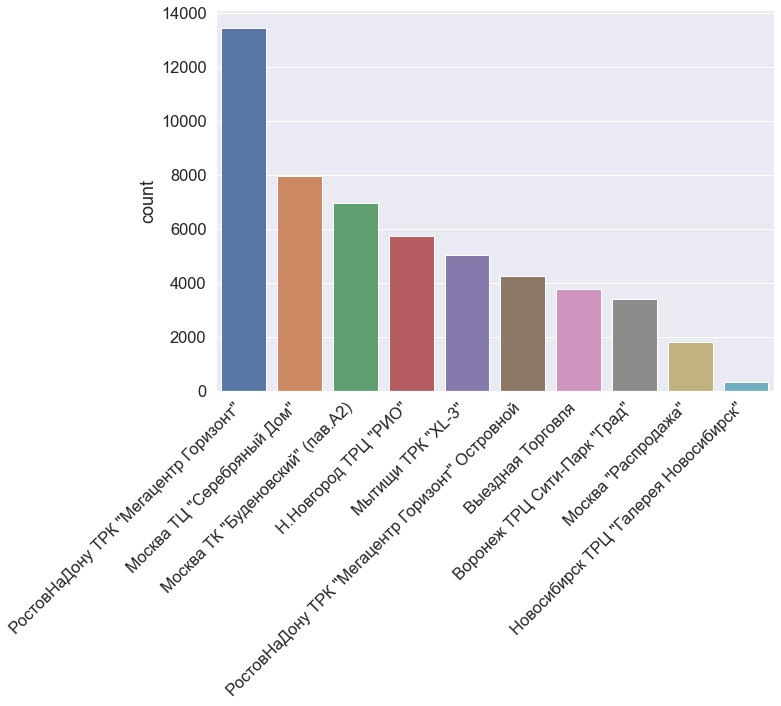

In [212]:
make_bar_plot(train_df, 'shop_name', top_n=-10, y_label='count');

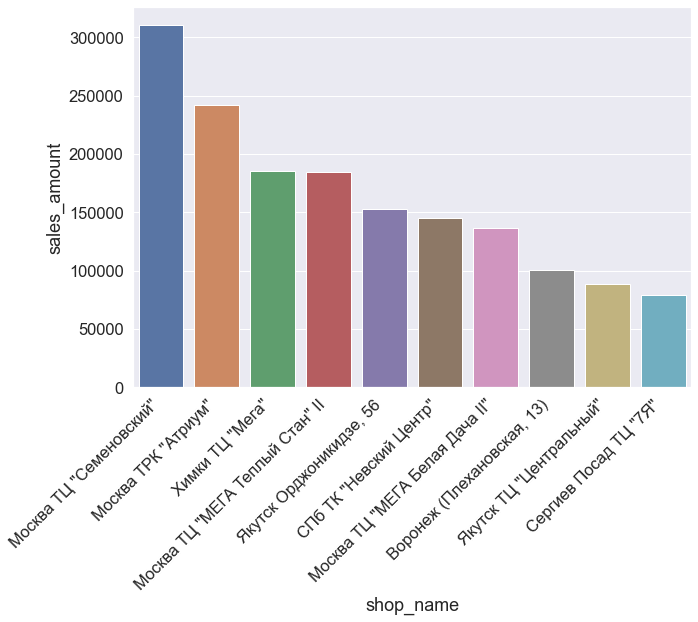

In [104]:
make_bar_plot(train_df, x='item_cnt_day', top_n=10, y_label='sales_amount', w_group=True, group_var='shop_name', agg_func='sum');

**Shops with the largest/smallest revenues are similar to the most/least popular shops**

In [6]:
df = train_df.groupby('shop_name').agg({'revenue':'sum'})
df.columns = ['shop_sales']
df.sort_values(by='shop_sales', inplace=True, ascending=False)
df.head()

,shop_sales
shop_name,
"Москва ТЦ ""Семеновский""",2.352170e+08
"Москва ТРК ""Атриум""",2.164806e+08
"Москва ТЦ ""МЕГА Теплый Стан"" II",1.597463e+08
"СПб ТК ""Невский Центр""",1.519170e+08
"Химки ТЦ ""Мега""",1.419397e+08


In [7]:
df.tail()

,shop_sales
shop_name,
"Москва ТЦ ""Серебряный Дом""",5772824.00
"Москва ТК ""Буденовский"" (пав.А2)",5621521.20
"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",4293586.85
"Воронеж ТРЦ Сити-Парк ""Град""",2349358.00
"Новосибирск ТРЦ ""Галерея Новосибирск""",377714.00


In [106]:
del df;

### Add items df to train data.

In [217]:
train_df = pd.merge(train_df, items_cats_df, on='item_id')
train_df.isna().sum() 

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
revenue               0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

**So most popular and unpopular items are approximately the same as we saw on the plot before merging dfs**

In [221]:
train_df.item_category_name.value_counts().head()

Кино - DVD                             564652
Игры PC - Стандартные издания          351591
Музыка - CD локального производства    339585
Игры - PS3                             208219
Кино - Blu-Ray                         192674
Name: item_category_name, dtype: int64

In [222]:
train_df.item_category_name.value_counts().tail()

Книги - Путеводители                 3
Книги - Открытки                     2
Аксессуары - PS2                     2
Книги - Познавательная литература    1
Игровые консоли - PS2                1
Name: item_category_name, dtype: int64

**The most/least expensive item categories. We can see, that the most expensive are game consoles and the least - books, food. So probably item category will also affect item_price**

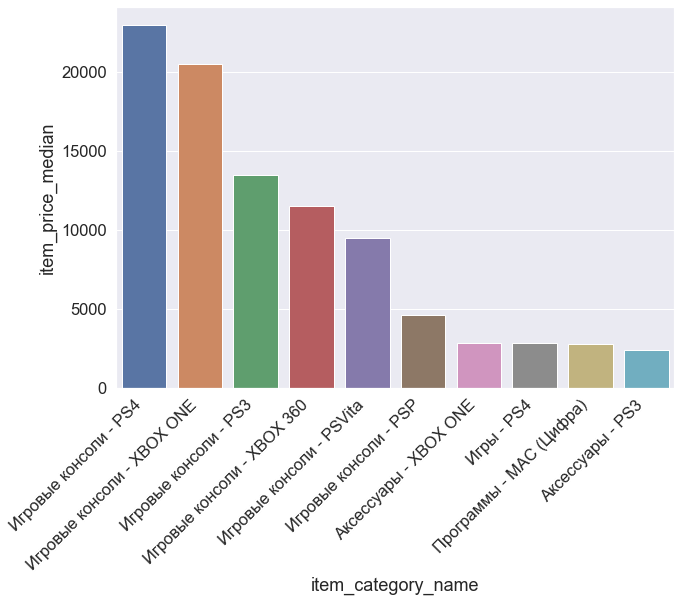

In [88]:
make_bar_plot(train_df, x='item_price', y_label='item_price_median', top_n=10, 
              w_group=True, group_var='item_category_name', agg_func='median');

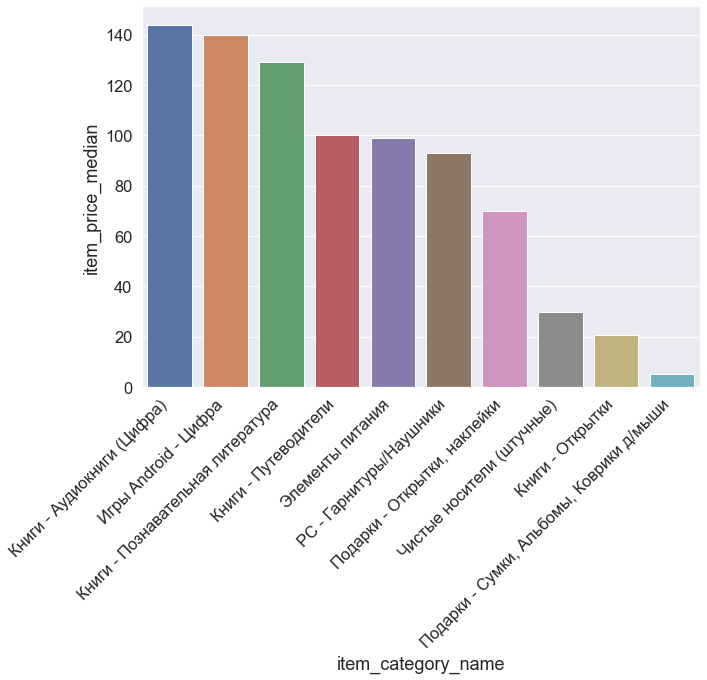

In [91]:
make_bar_plot(train_df, x='item_price', y_label='item_price_median', top_n=-10, 
              w_group=True, group_var='item_category_name', agg_func='median');

**The most sold items somehow connected with the most popular categories**. There are about 22.000 of unique item names in df (of which 11% have appeared only once in train data), for now I don't think that this variable will be useful, and also it's hard to encode or extarct features from it as in comparison in item category name or shop name

In [97]:
train_df.item_name.nunique()

21807

In [102]:
sum(train_df.item_name.value_counts() == 1)

2371

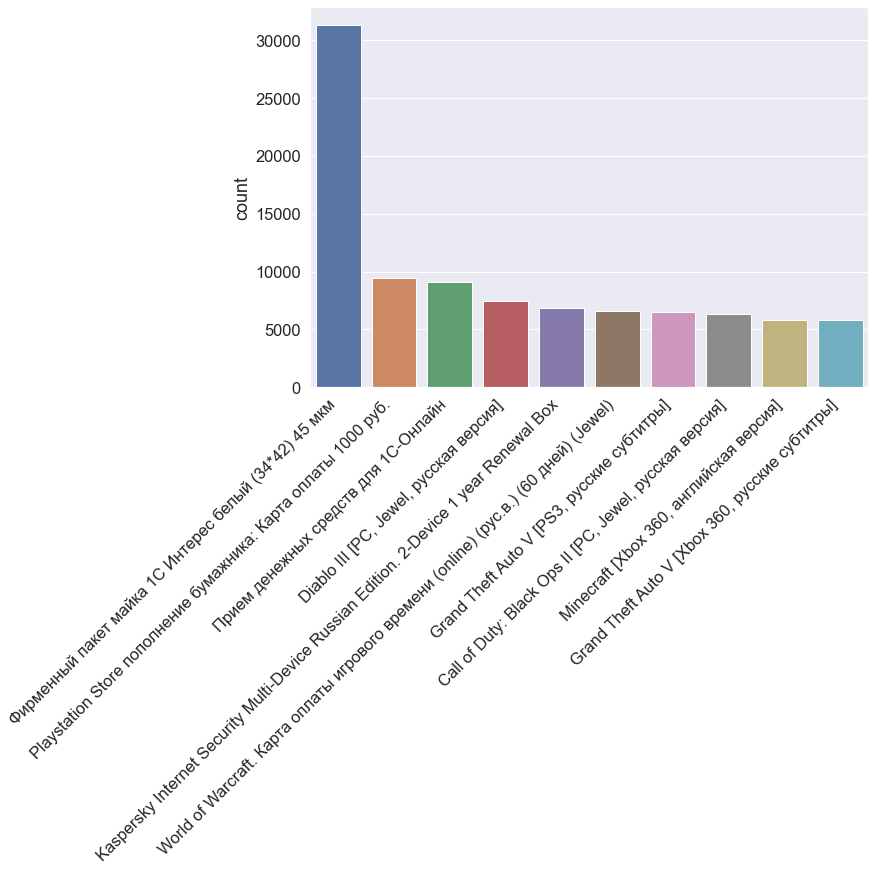

In [96]:
make_bar_plot(train_df, x='item_name', top_n=10, y_label='count');

## Data cleaning

In [14]:
# remove negative price values
train_df[train_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,shop_name,item_name,item_category_id,item_category_name
212565,2013-05-15,4,32,2973,-1.0,1.0,-1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


In [17]:
# find neighbours 
train_df[(train_df.shop_id==32)&(train_df.item_id==2973)&(train_df.date_block_num==4)&(train_df.item_price>0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,shop_name,item_name,item_category_id,item_category_name
212564,2013-05-23,4,32,2973,1249.0,1.0,1249.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3
212566,2013-05-06,4,32,2973,2499.0,1.0,2499.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


In [19]:
# take median of their item_price
median_price = train_df[(train_df.shop_id==32)&(train_df.item_id==2973)
                        &(train_df.date_block_num==4)&(train_df.item_price>0)].item_price.median()
train_df.loc[train_df.item_price < 0, 'item_price'] = median_price

## Explore sales, prices using merged train data with shop ids and item ids

In [108]:
df = train_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'sum',
                                                                   'item_cnt_day':'sum'})
df.columns = ['item_price', 'item_cnt']
df.reset_index(inplace=True)
df['month'] = df.date_block_num.apply(lambda x: x%12 + 1)

In [71]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt,month
0,0,2,27,2499.0,1.0,1
1,0,2,33,499.0,1.0,1
2,0,2,317,299.0,1.0,1
3,0,2,438,299.0,1.0,1
4,0,2,471,798.0,2.0,1


**So in December people are prone to buy items with the largest prices, the reson for this - Christmas, New Year's day and holidays**

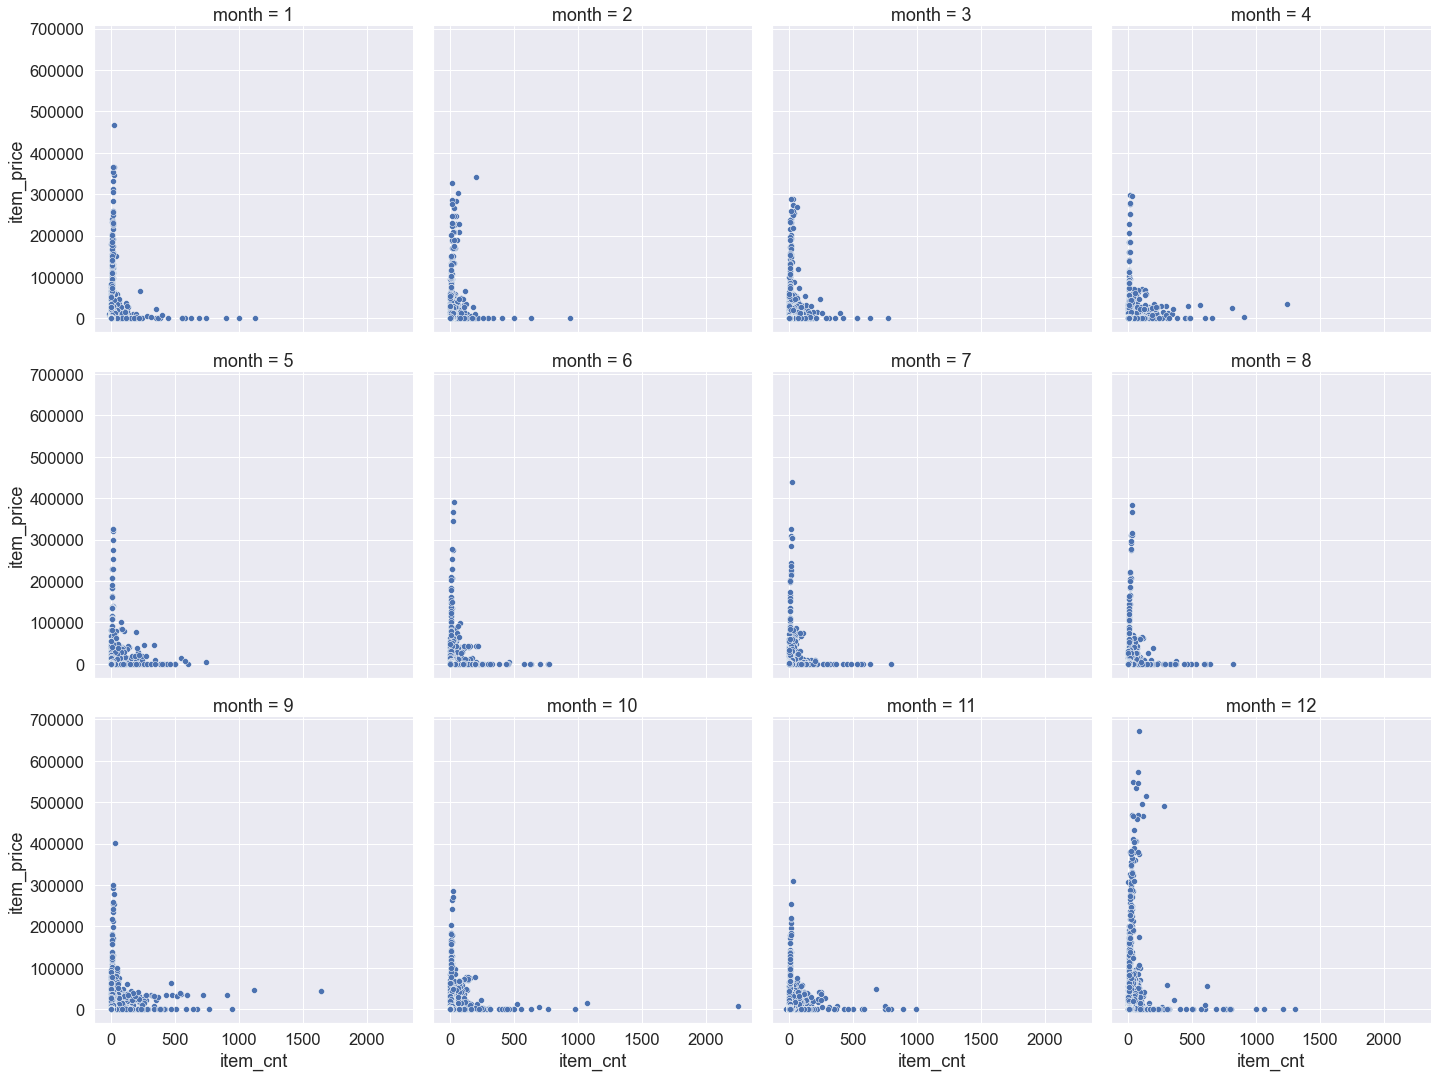

In [35]:
sns.relplot(data=df, x='item_cnt', y='item_price', col='month', col_wrap=4);

**This chart confirms, that during holidays in winter (date_block_num == 11 | 23) people make more than 5 purchases**. But during other month this varibale only shows, that people through years tend to buy less items_cnt>5 

In [105]:
df.item_cnt.quantile(0.9)

4.0

In [75]:
df['is_big_purchase'] = 0
df.loc[df.query('item_cnt > 5').index, 'is_big_purchase'] = 1

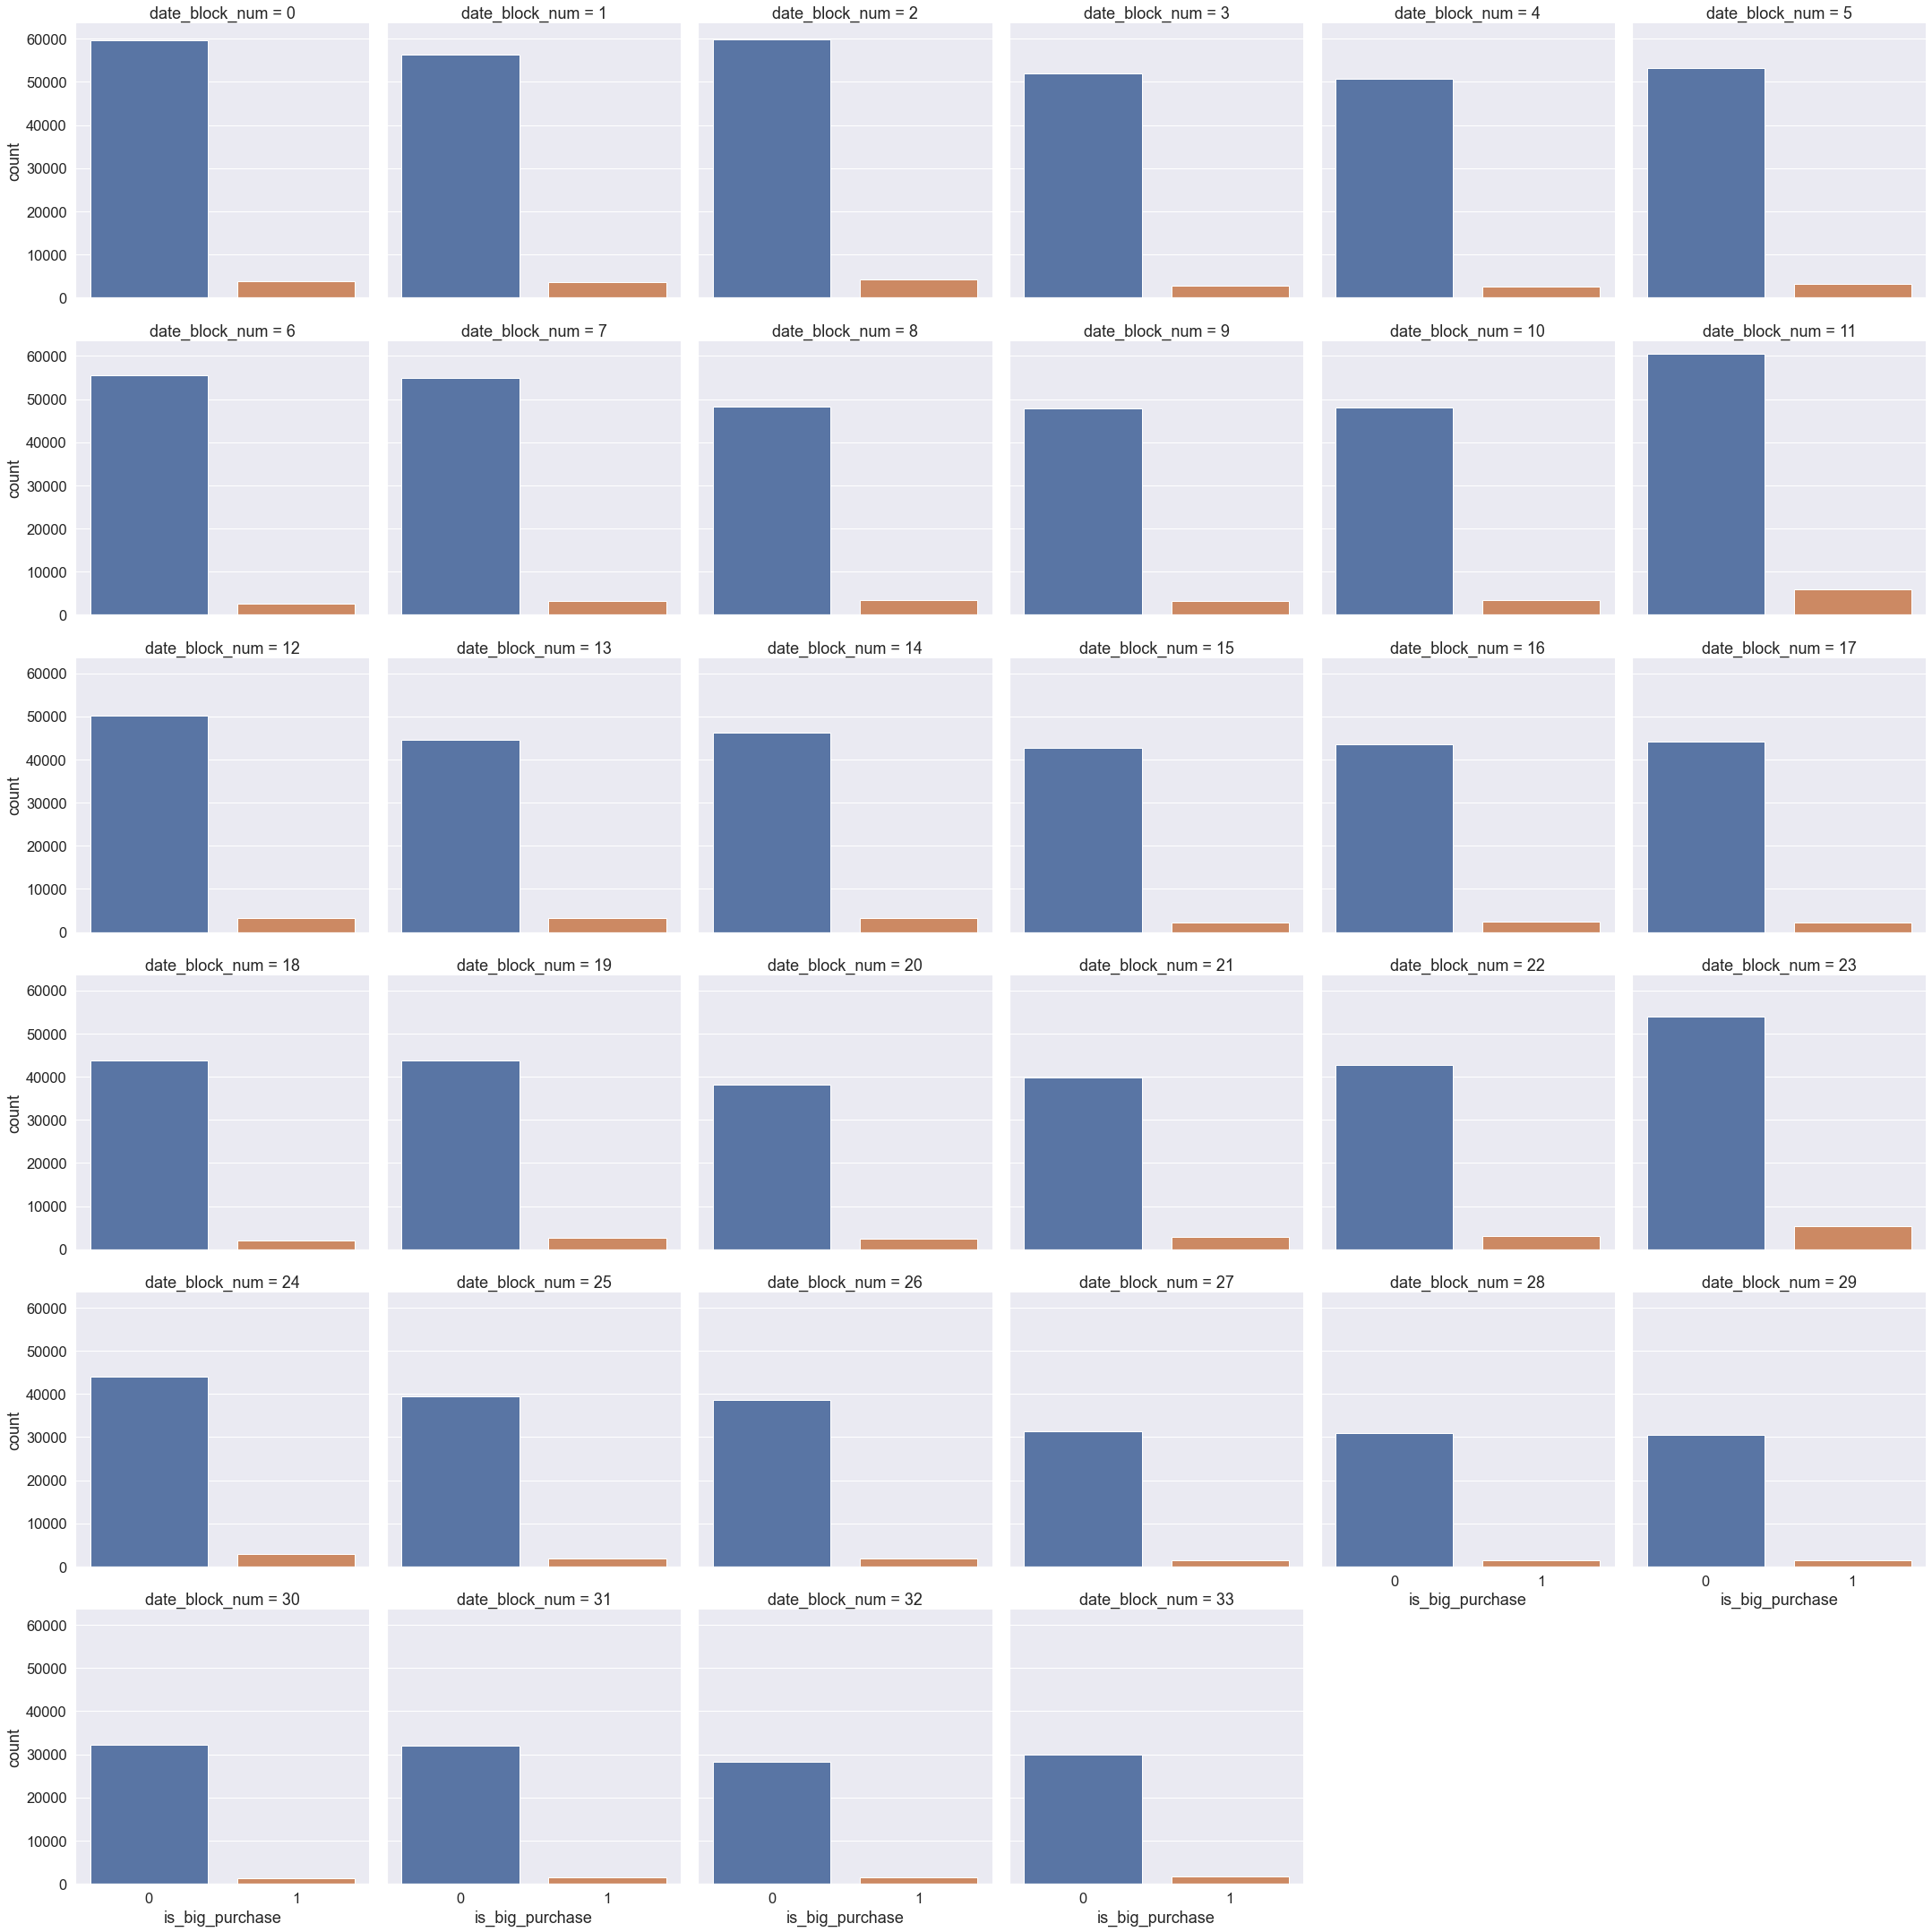

In [84]:
sns.catplot(data=df, x='is_big_purchase', col='date_block_num', col_wrap=6, kind='count')

In [247]:
df.item_price.describe().round()

count    1609124.0
mean        1625.0
std         5702.0
min            0.0
25%          249.0
50%          499.0
75%         1398.0
max       671930.0
Name: item_price, dtype: float64

**In december people buy more items with the price higher than the median**. Even though after December 2014, people buy such items more every month, but total purchases, whether it's an expensive or not, are getting smaller.

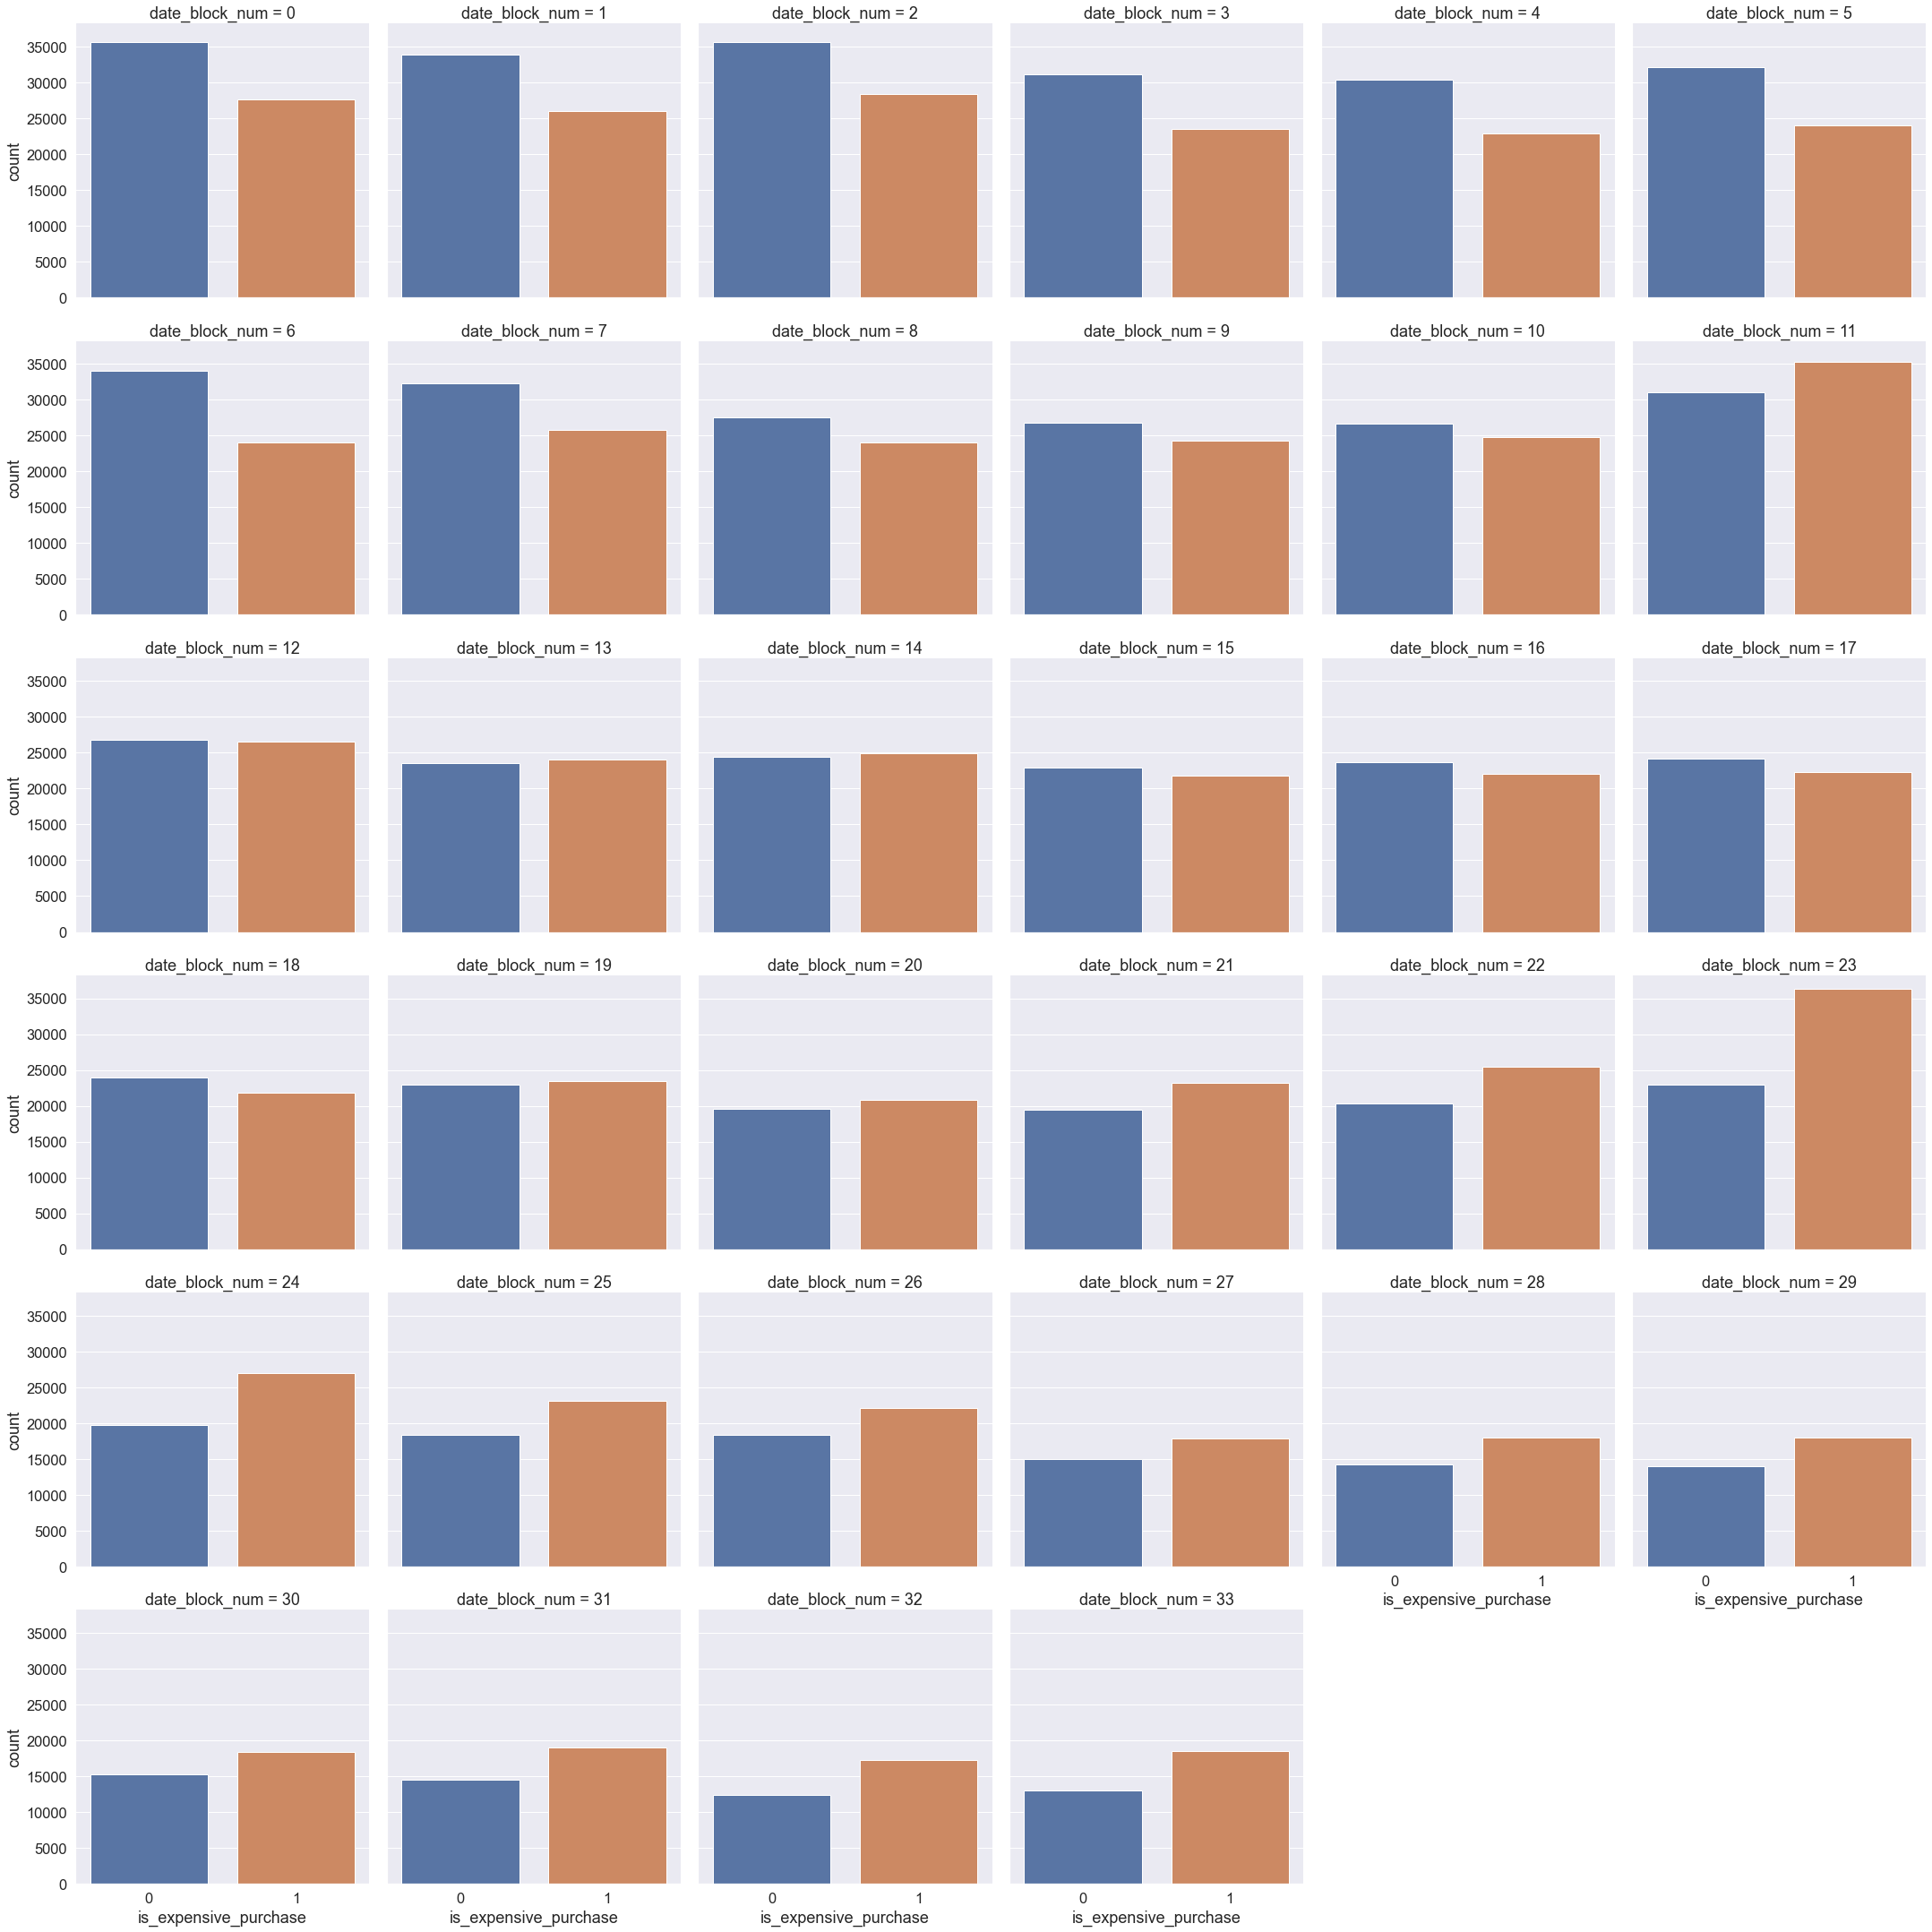

In [248]:
df['is_expensive_purchase'] = 0
df.loc[df.query('item_price > 499.0').index, 'is_expensive_purchase'] = 1
sns.catplot(data=df, x='is_expensive_purchase', col='date_block_num', col_wrap=6, kind='count');

## Feature engineering

In [109]:
train_df['city'] = train_df.shop_name.str.split(' ').map(lambda x: x[0])
train_df.loc[train_df.city == '!Якутск', 'city'] = 'Якутск'

split = train_df.item_category_name.str.split('-')
train_df['type'] = split.map(lambda x: x[0].strip())
train_df['subtype'] = split.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [272]:
train_df.to_csv('train_demo1.csv', index=False)
#test_df.to_csv('test_demo1.csv',index=False)
#items_cats_df.to_csv('items_demo1.csv',index=False)
#shops_df.to_csv('shops_demo1.csv',index=False)

In [2]:
train_df = pd.read_csv('train_demo1.csv')
#test_df = pd.read_csv('test_demo1.csv')
#items_cats_df = pd.read_csv('items_demo1.csv')
#shops_df = pd.read_csv('shops_demo1.csv')